# **<font color='#569098' size=20>Convolutional Neural Networks (CNNs)</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

**OBJECTIVES: By the end of this workshop you should be able to:**

* <font color='#e59454'> Identify and Define CNNs </font>
* <font color='#e59454'>Explore the convolution operation performed in a convolutional layer</font>
* <font color='#e59454'>Observe how CNNs learn and represent features from input images</font>

**_To save your work, please save a copy of this notebook into your  personal google drive._**

**<font color='#569098' size = 5> Table of Contents </font>**

**[Section 1: Convolutions in Numpy](https://colab.research.google.com/drive/1EqY_dIc2PGViDKwCwZFqP1v7gh-55TEu#scrollTo=8-xQx8VFGYWZ)**

**[Section 2: Training a Convolutional Neural Network](https://colab.research.google.com/drive/1EqY_dIc2PGViDKwCwZFqP1v7gh-55TEu#scrollTo=LyCghPWkGZ6j)**
* Defining a model
* Creating dataset
* Instantiating model
* Training


### <b> <font color='#569098'> Import Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy import signal as sg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

# <b> <font color='#569098'> Section 1: Convolutions in NumPy

Recall that a neural network (NN) is a hierarchical network of computational units or “neurons” for highly nonlinear function approximation. Each neuron’s input is a set of weighted upstream signals. The neuron treats this set of weighted inputs as a linear combination and optionally applies nonlinearity via an activation function.

In a **dense layer** like in the previous workshop, each neuron in the current layer is connected to every neuron in the previous layer, and every connection has it's own weight. These layers are expensive in terms of memory and computation. Alternatively, in a **convolutional layer** each neuron is only connected to a few nearby local neurons in the previous layer, and the same set of weights is used to connect them. This special structure allows CNNs to efficiently and robustly detect visual patterns in images.

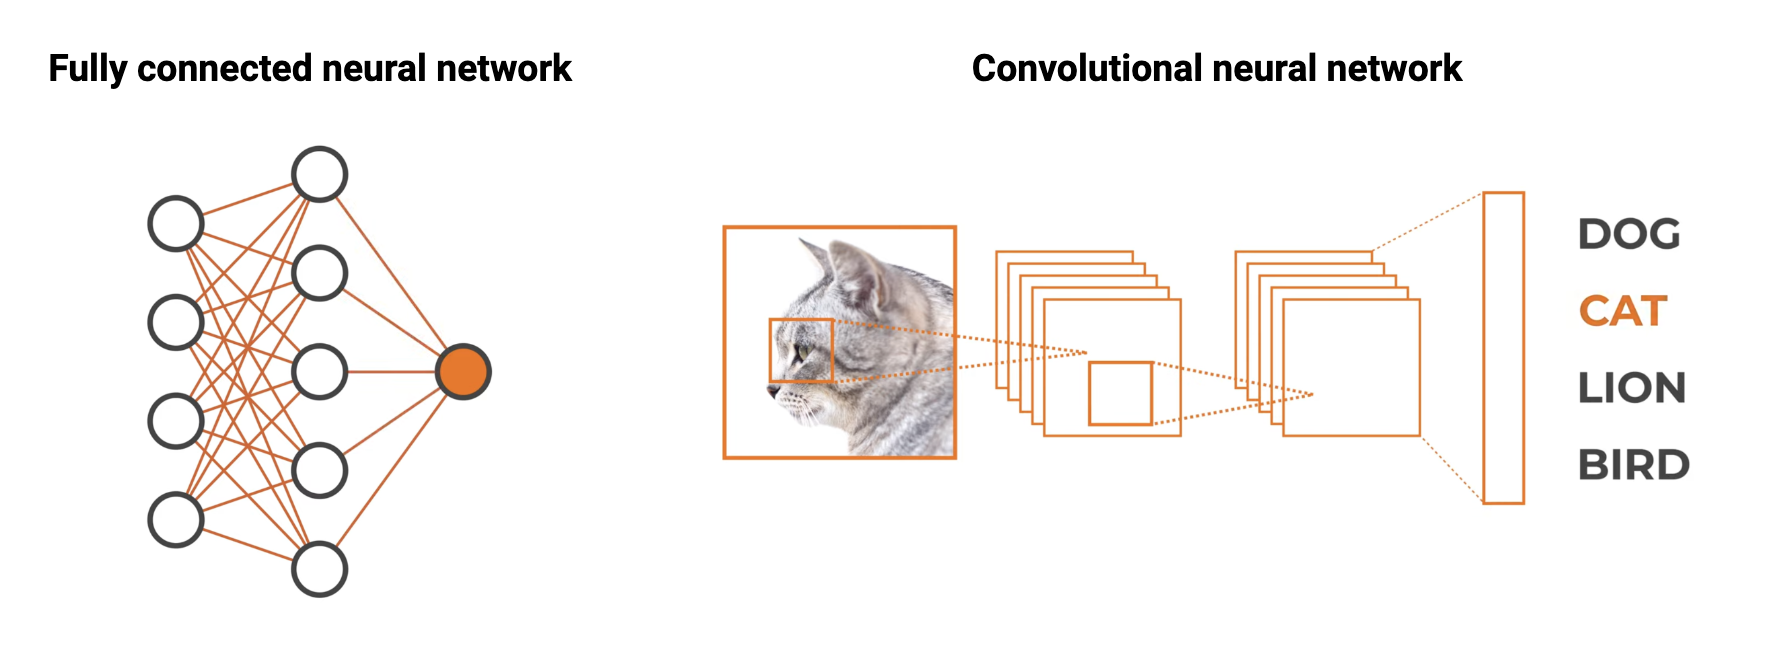

The word *convolutional* refers to the granularity reduction process that happens in this type of network. In the case of images, if you look inside a convolutional neural network, you will see a sliding window (called a kernel), sweeping across each pixel in your image and producing a blurrier version than the original. In the lingo, we would say that the image on the right is a convolution of our original image.

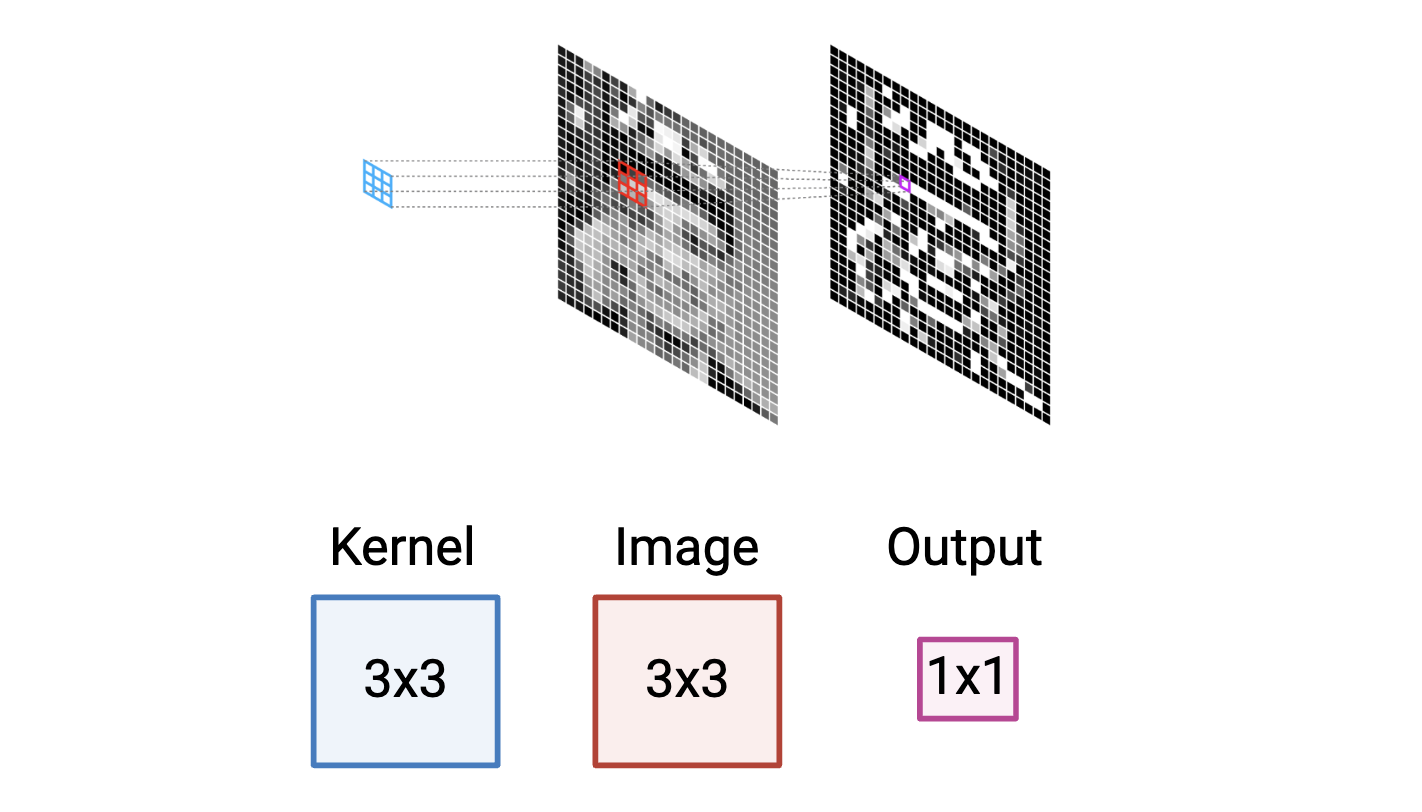

Let's first start with a one dimensional convolution operation. There are multiple methods to apply a kernel on a matrix: `With padding (full)`, `with padding (same)`, and `without padding (valid)`. In this example, we will do a convolution `without padding (valid)`.

Given an image $x$ and kernel $k$, the values of the convolved images $y$ is given by:

$$y(t) = \sum\limits_{j=0}^{K-1} k[j] \cdot x[t - j] $$

* $t$ is the index of a position in $y$
* $j$ is the index of the position in kernel $k$
* $K$ is the length of the kernel array

The convolution operation computes the output image $y$ by sliding the kernel over the input image and performing element-wise multiplication followed by summation at each point.



In [ ]:
k = [6, 2]
k_inv = k[::-1] # kernel inverted

x = [1, 2, 5, 4]

In [ ]:
k_inv

[2, 6]

In [ ]:
y1 = k_inv[0] * x[0] + k_inv[1] * x[1]
y2 = k_inv[0] * x[1] + k_inv[1] * x[2]
y3 = k_inv[0] * x[2] + k_inv[1] * x[3]
y1, y2, y3

(14, 34, 34)

If you look at the command reimplementation in numpy below, the convolution operation inverts kernel `k` under the hood before multiplying element-wise and summing. There are some interesting reasons for performing this inversion, but the TLDR is that by definition you first invert the kernel (otherwise, without the inversion, you are performing an operation known as *cross-correlation*), before performing element-wise multiplicatoin.

In [ ]:
# in numpy
y = np.convolve(k, x, "valid")
y

array([14, 34, 34])

Now consider the 5x5 matrix of an image's pixels.

<img src="https://ibm.box.com/shared/static/0s5v7doe2p5xuzifs47bxmmuwrn3kra2.bmp" alt="HTML5 Icon" style="width: 200px; height: 200px;">


We can convert each pixel to binary values (1 = white pixel, 0 = black pixel). To create a convolved matrix (feature map), we need a sliding window, also known as a **kernel**. In the animation below, we use a 3x3 filter. The values from the filter were multiplied element-wise with the original matrix (input image), then summed up. This process is repeated for each elemenet by sliding the filter over the whole original martix, ultimately generating the full convolved feature matrix.

 <img src="https://ibm.box.com/shared/static/fvutcm8jwa5j2o7xv2zzqyz2yu3zwhz4.gif" alt="HTML5 Icon" style="width: 450px; height: 300px;">


The 2D convolution is similar to the 1D operation performed earlier, where we take the dot product of kernel $K$ with each portion of the input image $I$

$$y[i, j] = \sum_{u=0}^{p-1} \sum_{v=0}^{q-1} K[u, v] \cdot I[i - u, j - v]$$

* $i$ and $j$ are th row and column indices of convolved image $y$
* $u$ and $v$ are the row and column indices of kernel $K$

Below we recreate the convolution animation

In [ ]:
# 2D image
I = [[1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0],
     [0, 0, 1, 1, 1],
     [0, 0, 1, 1, 0],
     [0, 1, 1, 0, 0]]

# 2D kernel
g = [[1, 0, 1],
     [0, 1, 0],
     [1, 0, 1]]

sg.convolve(g, I, "valid")

array([[4, 3, 4],
       [2, 4, 3],
       [2, 3, 4]])

In [ ]:
# let's expand the first two operations for clarity
# y[0][0]
y1 = g[0][0] * I[0][0] + g[0][1] * I[0][1] + g[0][2] * I[0][2]  + \
     g[1][0] * I[1][0] + g[1][1] * I[1][1] + g[1][2] * I[1][2]  + \
     g[2][0] * I[2][0] + g[2][1] * I[2][1] + g[2][2] * I[2][2]

# y[0][1]
y2 = g[0][0] * I[0][1] + g[0][1] * I[0][2] + g[0][2] * I[0][3]  + \
     g[1][0] * I[1][1] + g[1][1] * I[1][2] + g[1][2] * I[1][3]  + \
     g[2][0] * I[2][1] + g[2][1] * I[2][2] + g[2][2] * I[2][3]

y1, y2 # the first two values in the convolved feature matrix

(4, 3)

Before training our convolutional neural network, let's look at an example of convolving another image, a blurry version of a handwritten number

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.39MB/s]


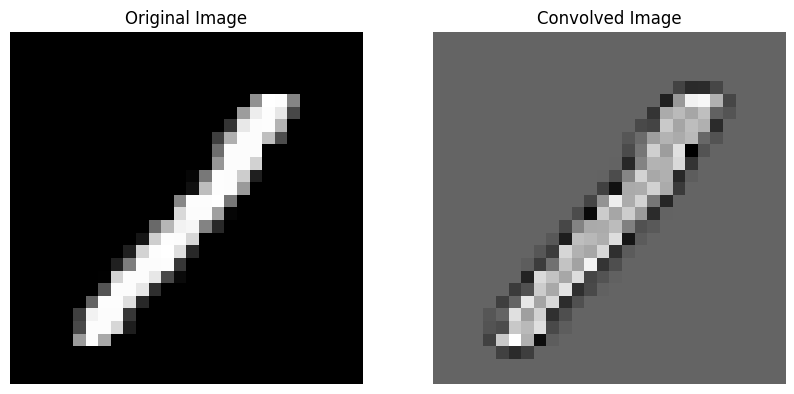

In [ ]:
# Function to perform convolution on an image with a given kernel
def convolve_image(image, kernel):
    # Convolve the image with the kernel
    convolved_image = convolve2d(image, kernel, mode='same', boundary='wrap')
    return convolved_image

# Function to display original and convolved images
def show_images(original_image, convolved_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(convolved_image, cmap='gray')
    plt.title('Convolved Image')
    plt.axis('off')

    plt.show()

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select a random MNIST image
idx = np.random.randint(len(mnist_dataset))
image, label = mnist_dataset[idx]

# Convert image to numpy array
image_np = image.squeeze().numpy()

# Example kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# Perform convolution
convolved_image = convolve_image(image_np, kernel)

# Crop the convolved image to match original dimensions
convolved_image_cropped = convolved_image[:image_np.shape[0], :image_np.shape[1]]

# Show original and convolved images
show_images(image_np, convolved_image_cropped)


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**


import random
from IPython.display import display, HTML

def create_quiz(question, correct_answer, decoy_answers, explanation):
    # Combine the correct answer with the decoy answers
    answers = [correct_answer] + decoy_answers

    # Shuffle the answers
    # random.shuffle(answers)

    # Generate the HTML code
    html_code = f"""
    <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
      <h3 style="word-wrap: break-word;">{question}</h3>
    """

    # Add each answer as a radio button
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
          <input type="radio" id="option{i}" name="quiz" value="{answer}">
          <label for="option{i}" id="label{i}">{answer}</label>
        </div>
        """

    # Add the submit button, explanation button, feedback section, and explanation section
    html_code += f"""
      <button onclick="checkAnswer()">Submit</button>
      <button onclick="showExplanation()">Show Explanation</button>
      <p id="feedback" style="font-weight: bold;"></p>
      <div id="explanation" style="display:none; margin-top: 20px; padding: 10px; border: 1px solid #ccc; background-color: #f9f9f9;">
        <h4>Explanation:</h4>
        <p>{explanation}</p>
      </div>
    </div>
    <script>
    function checkAnswer() {{
        var radios = document.getElementsByName('quiz');
        var correctAnswer = "{correct_answer}";
        var feedback = document.getElementById('feedback');
        var selectedOption = null;
        var selectedLabel = null;

        // Get the selected option
        for (var i = 0, length = radios.length; i < length; i++) {{
            if (radios[i].checked) {{
                selectedOption = radios[i].value;
                selectedLabel = document.getElementById('label' + i);
                break;
            }}
        }}

        // Provide feedback
        if (selectedOption) {{
            if (selectedOption === correctAnswer) {{
                feedback.textContent = "Correct!";
                feedback.style.color = "green";
                selectedLabel.style.color = "green";
            }} else {{
                feedback.textContent = "Incorrect.";
                feedback.style.color = "red";
                selectedLabel.style.color = "red";
            }}
        }} else {{
            feedback.textContent = "Please select an answer.";
            feedback.style.color = "orange";
        }}
    }}

    function showExplanation() {{
        var explanationDiv = document.getElementById('explanation');
        explanationDiv.style.display = "block";
    }}
    </script>
    """

    display(HTML(html_code))


question = "What is the purpose of the convolutional layer in a CNN?"
correct_answer = "To extract features from the input images by applying filters that detect edges, textures, and shapes."
decoy_answers = [
    "To randomly initialize the weights of the model.",
    "To combine different layers of the CNN into one."
]
explanation = "The convolutional layer applies filters to input images, helping the model detect low-level features like edges and textures, and higher-level features in deeper layers."
create_quiz(question, correct_answer, decoy_answers, explanation)


# <b> <font color='#569098'> Section 2: Training a Convolutional Neural Network


## <b> <font color='#569098'> Defining Model

In [ ]:
# dense neural network
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()

        # Fully connected layers
        self.d1 = nn.Linear(28 * 28, 128)
        self.d2 = nn.Linear(128, 128)  # Added another fully connected layer
        self.d3 = nn.Linear(128, 10)

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)  # Added another fully connected layer
        x = F.relu(x)
        x = self.d3(x)

        # Softmax activation
        out = F.softmax(x, dim=1)
        return out

# convolutional neural network
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

question = "What advantage does a CNN with multiple convolutional layers have?"
correct_answer = "It allows the network to capture progressively complex features at each layer."
decoy_answers = [
    "It helps downsample the input, reducing the number of computations required.",
    "It makes the model learn features in smaller image segments.",
    "It ensures each layer has identical filters for uniform feature extraction."
]
explanation = "Multiple convolutional layers enable the network to build upon learned features, progressing from edges to complex patterns."
create_quiz(question, correct_answer, decoy_answers, explanation)


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

question = "What effect does a higher learning rate have on the training process?"
correct_answer = "It increases the step size of each update, potentially speeding up convergence but risking instability."
decoy_answers = [
    "It decreases the step size, improving stability and precision.",
    "It has no impact on training speed or convergence.",
    "It reduces model accuracy by adding noise to gradients."
]
explanation = "A higher learning rate speeds up training by taking larger steps, but can overshoot optimal points, causing instability."
create_quiz(question, correct_answer, decoy_answers, explanation)


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

question = "What is the purpose of the final fully connected layer in a CNN?"
correct_answer = "It combines features from previous layers to make final predictions."
decoy_answers = [
    "It normalizes feature maps for the final output.",
    "It helps detect edges within the feature maps.",
    "It increases the spatial resolution of the output."
]
explanation = "The fully connected layer aggregates features extracted by previous layers to make classification predictions."
create_quiz(question, correct_answer, decoy_answers, explanation)


## <b> <font color='#569098'>Creating dataset
To prepare datasets in PyTorch we will be using the `DataLoader`. The PyTorch DataLoader is a utility that helps efficiently load and iterate over datasets during the training or testing process in PyTorch. Here, we define the batch size for loading data, which determines the number of samples processed together during each iteration of training or testing. Additionally, we define a transformation pipeline using `transforms.Compose`. In this case, we have only one transformation, transforms.ToTensor(), which converts PIL Image or numpy array to a PyTorch tensor.

We then create a DataLoader for the training dataset (trainset). We specify the batch size (batch_size=BATCH_SIZE), which determines the number of samples to load per batch. Setting shuffle=True shuffles the data at every epoch, which helps in randomizing the order of samples during training, thus preventing the model from learning any spurious patterns based on the order of the data. num_workers=2 indicates the number of subprocesses to use for data loading. This speeds up the data loading process by parallelizing data loading operations.

Here we will use the MNIST dataset, which is  a widely used dataset in the field of machine learning and computer vision. It consists of a collection of 28x28 pixel grayscale images of handwritten digits (0-9), along with their corresponding labels indicating the digit they represent. Each image is labeled with the digit it contains.

In [ ]:
%%capture
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)



We can visualize datapoints of our dataset

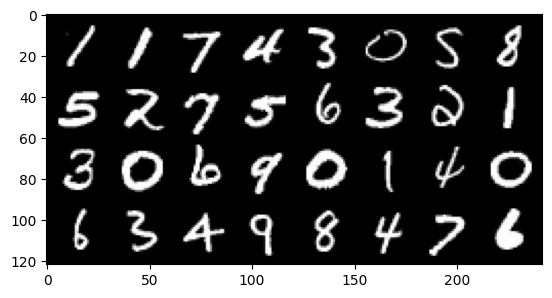

In [ ]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)

## show images
for i in range(1):  # Assuming you want to show 4 images
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    plt.show()

In [ ]:
# check the dimensions
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## <b> <font color='#569098'>Instantiating model

In [ ]:
## test the model with 1 batch
model = ConvModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## <b> <font color='#569098'>Training

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6087 | Train Accuracy: 85.68
Epoch: 1 | Loss: 1.4915 | Train Accuracy: 97.31
Epoch: 2 | Loss: 1.4816 | Train Accuracy: 98.22
Epoch: 3 | Loss: 1.4767 | Train Accuracy: 98.68
Epoch: 4 | Loss: 1.4744 | Train Accuracy: 98.87


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.20


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

question = "During the backpropagation process in CNNs, what is being updated?"
correct_answer = "The weights of the filters are updated to minimize the loss."
decoy_answers = [
    "The pixel values of the input images are adjusted to fit the model.",
    "The number of filters in each layer is modified to improve accuracy.",
    "The dimensions of the feature maps are changed."
]
explanation = "During backpropagation, the gradients of the loss function with respect to the filter weights are computed, and these weights are updated to minimize the loss."
create_quiz(question, correct_answer, decoy_answers, explanation)


In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

question = "During the training loop, why is it important to zero out gradients using `optimizer.zero_grad()`?"
correct_answer = "To prevent gradients from accumulating across batches, ensuring correct updates to the model."
decoy_answers = [
    "To reset the weights of the model after each epoch.",
    "To clear the model parameters so they can be re-initialized.",
    "To reduce the learning rate with each batch."
]
explanation = "Zeroing out gradients prevents unwanted accumulation, ensuring that only gradients from the current batch are used for updates."
create_quiz(question, correct_answer, decoy_answers, explanation)


Let's select an image from our dataset and pass it through our convolutional layer in the trained model. We can extract and visualize the feature maps generated by this convolutional layer in response to the input image. This visualization will help us understand what kinds of features the CNN learns to detect, such as edges and textures.

The type of information captured by this kernel depends on its weights, which are learned during the training process. However, with a 3x3 kernel size, the convolution operation typically captures local spatial patterns or features in the input image. These patterns could include edges, corners, textures, or other visual attributes present in the image. Since we have 32 output channels, each channel in the output feature map will capture different aspects or variations of these local patterns, providing a richer representation of the image content.

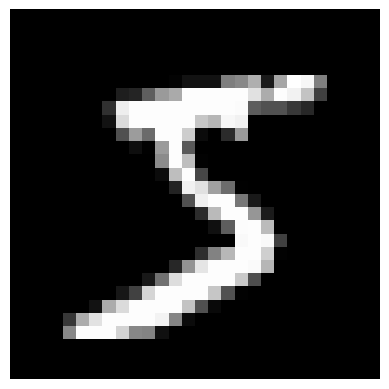

In [ ]:
# Access the first image from the training set
image, _ = trainset[0]

# Plot the image
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

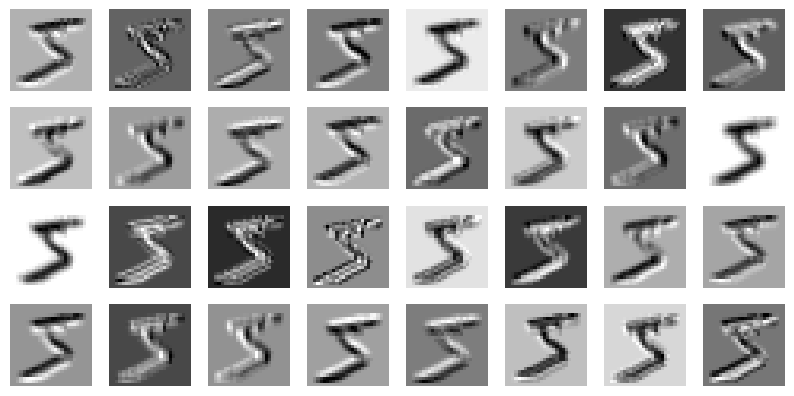

In [ ]:
# Choose an image from the dataset
image, _ = trainset[0]  # Choose any image from the dataset

# Convert the image to a tensor and move it to the appropriate device
image = image.unsqueeze(0).to(device)

# Get the feature maps from a specific convolutional layer
conv_layer = model.conv1  # Choose the convolutional layer you want to visualize
activation = conv_layer(image)

# Plot the feature maps
plt.figure(figsize=(10, 10))
for i in range(activation.size(1)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(activation.squeeze().detach().cpu().numpy()[i], cmap='gray')
    plt.axis('off')
plt.show()


Image Credit
* Figure 2: Convolving an image https://gregorygundersen.com/blog/2017/02/24/cnns/
* Figure 3: 5x5 pixel image https://ibm.box.com/shared/static/0s5v7doe2p5xuzifs47bxmmuwrn3kra2.bmp
* Figure 4: Kernel sweeping image animation https://ibm.box.com/shared/static/fvutcm8jwa5j2o7xv2zzqyz2yu3zwhz4.gif

Add the wandb (weights and biases) module to colab to efficiently track your training live!

Make an account on the wandb website to log and access all of your projects, create project reports, run hyperparameter searches and more.

Wandb is a widely used logging module used to track architecture performance and it's a worthwhile tool to learn how to use.

Create an account (you can use your student JHU account) here: https://wandb.auth0.com/login?state=hKFo2SBFTXR0eVRGQ3F2V1ZPQ3hfZ29seTVSdzhzcVkxWEVzN6FupWxvZ2luo3RpZNkgdjVEMjdCdVc4ZzY1UHBPLVRhakt3NnN5NVZ2b25YU0qjY2lk2SBWU001N1VDd1Q5d2JHU3hLdEVER1FISUtBQkhwcHpJdw&client=VSM57UCwT9wbGSxKtEDGQHIKABHppzIw&protocol=oauth2&nonce=aFV4UGtDY0gtfmphLUxtbw%3D%3D&redirect_uri=https%3A%2F%2Fapi.wandb.ai%2Foidc%2Fcallback&response_mode=form_post&response_type=id_token&scope=openid%20profile%20email&signup=true


Follow the simple steps below to start using wandb in colab to track your models. We'll only be tracking training data here as a minimum tool, but go through this in depth tutorial: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb#scrollTo=TxUlHUj52t-d



In [ ]:
import random

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

#initialize a wandb instance with relevant data:
wandb.init(
        project="pytorch-intro",
        config={
            "epochs": 10,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            }) #feel free to add other metadata like what optimizers you used etc.


#Put the following line in both your training and validation loops so you can track how performance changes in both scenario
#You can change variable names such as frm 'train/loss' to 'test/loss', 'accuracy', etc. and the corresponding variables will be plotted in wandb.
#Make sure your information is put in a dictionary, or else you'll have an error!
wandb.log({"epoch": epoch, "train/loss": loss})

#After your training loop, run
wandb.finish()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


epoch,▁
train/loss,▁
epoch,4
train/loss,1.52396


In [ ]:
#Putting it all together:

#🐝  import the module in & login to your account
!pip install wandb -qqq
import wandb
wandb.login() #Go to bottom of cell and followw instructions. It will ask for an API from a given link that's connected to your account. Make sure you're logged into wandb before running this cell!

#🐝 initialize a wandb instance with relevant data:
wandb.init(
        project="CNN_Classifier",
        config={
            "epochs": num_epochs,
            "lr":learning_rate,
            })

#Setup training loop:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        #🐝 insert training logging step here:
        wandb.log({"epoch": epoch, "train/loss": loss})

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))
    #🐝 If we did a validation loop, we'd insert the logging step here:

#🐝 finish wandb run
wandb.finish()

wandb: WARNING Unable to verify login in offline mode.


Epoch: 0 | Loss: 1.4725 | Train Accuracy: 99.05
Epoch: 1 | Loss: 1.4706 | Train Accuracy: 99.22
Epoch: 2 | Loss: 1.4701 | Train Accuracy: 99.27
Epoch: 3 | Loss: 1.4691 | Train Accuracy: 99.36
Epoch: 4 | Loss: 1.4680 | Train Accuracy: 99.47


epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆██████
train/loss,█▁▅▂▁▁▁▁▁▁▁▂▄▁▁▁▁▁▁▆▁▂▁▁▁▁▁█▁▁▁▁▁▁▄▁▁▁▄▆
epoch,4
train/loss,1.46115
